### In this notebook, We will pretrained a GPT model on unlabel Data

In [1]:
#fIRST WE INSTANTIATE A gpt MODEL USING CLASS FROM PREVIOUS CHAPTER
import torch
import torch.nn as nn
import sys
sys.path.append('..')
from utils import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,   #A
    "emb_dim": 768,       
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,           #B
    "qkv_bias": False,
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
#A We shorten the context length from 1024 to 256 tokens to be abble to train on our computer faster
#B It's possible and common to set dropout to 0.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
#utils for token -<> text conversion
import tiktoken
from utils import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) #add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) #remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you 960esame WindsorFE Keith awaitedSer seriously Estimated stren


In [3]:
#Calculating the text generation loss
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
[40, 1107, 588]]) # "I really like"]
#Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
[107, 588, 11311]]) # " really like chocolate"]

In [4]:
with torch.no_grad(): #A
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape)

#A Disable gradient tracking since we are not training, yet

torch.Size([2, 3, 50257])


In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[13207],
         [  552],
         [42826]],

        [[18236],
         [ 1775],
         [ 7055]]])


In [6]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
# When we decode these tokens, we find that these output tokens are quite different from
# the target tokens we want the model to generate:
# Targets batch 1: effort moves you
# Outputs batch 1: hole compNetflix

Targets batch 1:  effort moves you
Outputs batch 1: hole compNetflix


In [7]:
#text evaluation function
# For each of the two input texts, we can print the initial softmax probability scores
# corresponding to the target tokens via the following code:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([5.0559e-05, 2.4350e-05, 8.5685e-06])
Text 2: tensor([2.1986e-05, 3.3314e-05, 5.4969e-06])


In [8]:
#applying logarith to the probas
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("log probabilities:", log_probas)
#Working with logarithms of probability scores is more manageable in mathematical
# optimization than handling the scores directly

log probabilities: tensor([ -9.8924, -10.6230, -11.6674, -10.7251, -10.3095, -12.1113])


In [9]:
#we combine to the average
avg_log_probas = torch.mean(log_probas)
print("avg_log-probas:", avg_log_probas)

avg_log-probas: tensor(-10.8881)


In [10]:
# in deep learning, the common practice isn't to push the average log probability
# up to 0 but rather to bring the negative average log probability down to 0. The negative
# average log probability is simply the average log probability multiplied by -1
neg_avg_log_probas = -avg_log_probas 
print("neg_avg_log-probas:", neg_avg_log_probas) #cross entropy loss (the loss turning from negative to positive)


neg_avg_log-probas: tensor(10.8881)


In [11]:
# let's briefly recall the shape of the logits and
# target tensors
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [12]:
# For the cross entropy_loss function in PyTorch, we want to flatten these tensors by
# combining them over the batch dimension

logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Logits flat shape:", logits_flat.shape)
print("Targets flat shape:", targets_flat.shape)

Logits flat shape: torch.Size([6, 50257])
Targets flat shape: torch.Size([6])


In [13]:
# " the loss"
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross entropy loss:", loss)

Cross entropy loss: tensor(10.8881)


In [14]:
#load the training text
file_path = '../data_loading_and_tokenization/the-verdict.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text_data = f.read()

#check the number of characters and tokens in the dataset
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [15]:
# Next, we divide the dataset into a training and a validation set and use the data loaders
# from chapter 2 to prepare the batches for LLM trainin

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Using the train_data and val_data subsets, we can now create the respective data loader
reusing the create_dataloader_v1 code from chapter 2

In [16]:
import importlib, utils
importlib.reload(utils) #pour que les modifications dans utils soient prises en compte

from utils import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [17]:
import utils
print(dir(utils))


['DataLoader', 'Dataset', 'FeedForward', 'GELU', 'GPTDatasetV1', 'GPTModel', 'GPT_CONFIG_124M', 'LayerNorm', 'MultiHeadAttention', 'TransformerBlock', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calc_loss_batch', 'calc_loss_loader', 'create_dataloader_v1', 'evaluate_model', 'generate', 'generate_and_print_sample', 'generate_text_simple', 'nn', 'text_to_token_ids', 'tiktoken', 'token_ids_to_text', 'torch', 'train_model_simple']


In [18]:
#testing the dataloader
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [19]:
# we implement a utility function to calculate the cross entropy loss of a given batch
# returned via the training and validation loader:

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device) #A
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

#A the transfer to a given device allows us to transfer the data to a GPU

We can now use this calc_loss_batch utility function, which computes the loss for a single
batch, to implement the following calc_loss_loader function that computes the loss over
all the batches sampled by a given data loader

In [20]:
#Function to compute the training and validation loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)                                  #A
    else:
        num_batches = min(num_batches, len(data_loader))                #B

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                    #C
        else:
            break

    return total_loss / num_batches                                       #D



#A Iterative over all batches if no fixed num_batches is specified
#B Reduce the number of batches to match the total number of batches in the data loader if num_batches
#exceeds the number of batches in the data loader
#C Sum loss for each batch
#D Average the loss over all batches

Let's now see this calc_loss_batch function in action, applying it to the training and
validation set loaders

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #A
model.to(device)
with torch.no_grad(): #B
    train_loss = calc_loss_loader(train_loader, model, device) #C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

#A If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any
#changes to the code
#B Disable gradient tracking for efficiency because we are not training, yet
#C Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

Training loss: 10.997285101148817
Validation loss: 10.988701820373535


### Trainning an LLM

While the evaluate_model function gives us a numeric estimate of the model's training
progress, this generate_and_print_sample text function provides a concrete text example
generated by the model to judge its capabilities during training.

In [22]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() #A
    with torch.no_grad(): #B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

#A Dropout is disabled during evaluation for stable, reproducible results
#B Disable gradient tracking, which is not required during evaluation, to reduce the computational overhead

In [23]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()

In [24]:
#simple training function
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []  #A
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):                       #B
        model.train()  #training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                        #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                              #D
            optimizer.step()                             #E
            tokens_seen += input_batch.numel()
            global_step +=1


            if global_step %eval_freq  ==0 :             #F
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}):" 
                      f" Train loss {train_loss:.4f}, Val loss {val_loss:.4f}")
                
        generate_and_print_sample(model, tokenizer,device, start_context) #G

    return train_losses, val_losses, track_tokens_seen

#A Initialize lists to track losses and tokens seen
#B Start the main training loop
#C Reset loss gradients from previous batch iteration
#D Calculate loss gradients
#E Update model weights using loss gradients
#F Optional evaluation step
#G Print a sample text after each epoch

ADAMW
Adam optimizers are a popular choice for training deep neural networks. However, in
our training loop, we opt for the AdamW optimizer. AdamW is a variant of Adam that
improves the weight decay approach, which aims to minimize model complexity and
prevent overfitting by penalizing larger weights. This adjustment allows AdamW to
achieve more effective regularization and better generalization and is thus frequently
used in the training of LLMs

In [25]:
#lets train using AdamW optimiser and with 10 epochs
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1) #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs,
    eval_freq=5 ,
    eval_iter=1, 
    start_context="Every effort moves you",
    tokenizer=tokenizer
)
#A The .parameters() method returns all trainable weight parameters of the model

/home/ensimag/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Ep 1 (Step 000000): Train loss 9.9008, Val loss 9.9908
Ep 1 (Step 000005): Train loss 8.1473, Val loss 8.3652
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.7714, Val loss 7.0549
Ep 2 (Step 000015): Train loss 6.4928, Val loss 6.5674
Every effort moves you, and,, and,,,,,,, and, and,,,, the,,,,,,,,, the,, the, and,, the,,, the, and,,,,,,
Ep 3 (Step 000020): Train loss 5.7501, Val loss 6.4851
Ep 3 (Step 000025): Train loss 4.4076, Val loss 6.5411
Every effort moves you, and I had"                                             
Ep 4 (Step 000030): Train loss 5.4800, Val loss 6.4137
Ep 4 (Step 000035): Train loss 4.0277, Val loss 6.2569
Every effort moves you--I was his the picture and I was the his I was his I was his I was the picture--and it was the picture to the picture.                   
Ep 5 (Step 000040): Train loss 3.7084, Val loss 6.2470
Every effort moves you know the fact, and I felt--I to the fact the picture.         

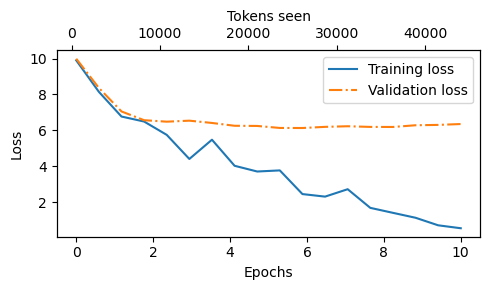

In [26]:
#let's plot training loss and validation losses side by side
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny()                           #A
    ax2.plot(tokens_seen, train_losses, alpha=0)  #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#A Create a second x-axis that shares the same y-axis
#B Invisible plot for aligning ticks

we can see that after epoch2 the model is overfitting. that's not  supprising as we have a small dataset and we use many epochs.
In practice for big llm, there is more data and only one epoch.

In [27]:
#Decoding strategies to control randomless
#we will cover two techniques, temperature scaling, and top-k sampling,to improve our generated_text_simple function

In [28]:
model.to("cpu") #we don't need GPU here for our small examples
model.eval() #we are no more training

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

Next, we plug the GPTModel instance (model) into the generate_text_simple function,
which uses the LLM to generate one token at a time:

In [29]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
        model=model,
        idx=text_to_token_ids("Every effort moves you", tokenizer),
        max_new_tokens=25,
        context_size=GPT_CONFIG_124M["context_length"]
    )
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




temperature scaling

In [30]:
#example to start with
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [31]:
# let's assume the LLM is given the start context "every effort moves you" and
# generates the following next-token logits
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

#then we have:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [32]:
#now instead of using armax, we are going to use multinomial function

torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


The multinomial
function samples the next token proportional to its probability score. In other words,
"forward" is still the most likely token and will be selected by multinomial most of the
time but not all the time. To illustrate this, let's implement a function that repeats this
sampling 1000 times

In [33]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


This way, the model can produces other word than just forward for the same logits. we can further control the distribution and selection process using temperature scaling -- a fancy description for dividing the logits by a number greater than 0:



In [34]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim =0)
    

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and Temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions. Let's illustrate this by plotting the original probabilities alongside
probabilities scaled with different temperature values

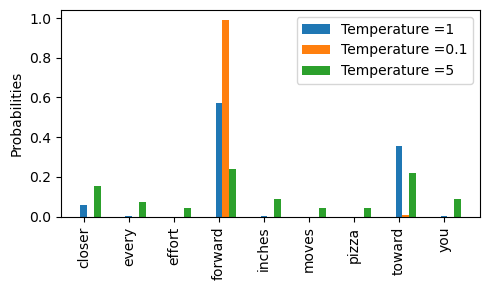

In [35]:
temperatures = [1, 0.1, 5] #A
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x+i*bar_width, scaled_probas[i], bar_width, label=f'Temperature ={T}')
ax.set_ylabel('Probabilities')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()
#A Original, lower, and higher confidence

we can see in Figure 5.14, applying very small temperatures, such as 0.1, will
result in sharper distributions such that the behavior of the multinomial function selects
the most likely token (here: "forward") almost 100% of the time, approaching the
behavior of the argmax function. Vice versa, a temperature of 5 results in a more uniform
distribution where other tokens are selected more often. This can add more variety to the
generated texts but also more often results in nonsensical text. For example, using the
temperature of 5 results in texts such as "every effort moves you pizza" about 4% of
the time.

In [36]:
temperatures = [1, 0.1, 5] #A
for temperature in temperatures:
    print(f"========================T={temperature}=========")
    scaled_probas = softmax_with_temperature(next_token_logits, temperature)
    print_sampled_tokens(scaled_probas)
    

========================T=1=========
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you
========================T=0.1=========
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
========================T=5=========
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


Top-k sampling

IN top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens
and exclude all other tokens from the selection process by masking their probability scores,

Ex: 

Using top-k sampling with k=3, we focus on the 3 tokens associated with the highest logits and
mask out all other tokens with negative infinity (-inf) before applying the softmax function. This results in a
probability distribution with a probability value 0 assigned to all non-top-k tokens.

In [37]:
#implementation
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Subsequently, we apply PyTorch's where function to set the logit values of tokens that are
below the lowest logit value within our top-3 selection to negative infinity (-inf).

In [38]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1], #A
    input=torch.tensor(float('-inf')),            #B
    other = next_token_logits                      #C
)
print(new_logits)
#A Identifies logits less than the minimum in the top 3
#B Assigns -inf to these lower logits
#C Retains the original logits for all other tokens

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [39]:
#Lastly, let's apply the softmax function to turn these into next-token probabilities:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Then we modify the text generation function to choose the next token among these 3  non-zero probability scores 

In [40]:
#A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size, temperature =1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):                         #A
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # just the probas for last token
        if top_k is not None:                               #B
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
            logits
            )

        if temperature > 0.0:                                  #C
            logits = logits / temperature     
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:                                                  #D
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
    
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

#A For-loop is the same as before: Get logits, and only focus on last time step
#B In this new section, we filter logits with top_k sampling
#C This is the new section where we apply temperature scaling
#D Carry out greedy next-token selection as before when temperature scaling is disabled
#E Stop generating early if end-of-sequence token is encountered and eos_id is specified

Lets's try it

In [41]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Hello I am ", tokenizer).to(device),
    max_new_tokens=15,
    context_size= GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0.7
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Hello I am  thought Jack Gisburn rather a cheap genius--I told Mrs.



### Loading and Saving model weights in pytorch


In [42]:
#using torch
torch.save(model.state_dict(), "model.pth")


Then, after saving the model weights via the state_dict, we can load the model
weights into a new GPTModel model instance as follows

In [43]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval() # evaluation mode (disable dropout layer)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

If we plan to continue pretrainning a model, saving optimizer is alse recomended
Adaptive optimizers such as AdamW store additional parameters for each model weight.
AdamW uses historical data to adjust learning rates for each model parameter dynamically.
Without it, the optimizer resets, and the model may learn suboptimally or even fail to
converge properly, which means that it will lose the ability to generate coherent text. Using
torch.save, we can save both the model and optimizer state_dict contents as follows:

In [44]:
torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimiser.pth"
)

Then, we can restore the model and optimizer states as follows by first loading the saved
data via torch.load and then using the load_state_dict method:

In [45]:
checkpoint = torch.load("model_and_optimiser.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### Now we are going to load weight of openai gpt2 and load it in our Model

We use the dowload_and_load_gt2 function provide in course materials

In [50]:
import importlib, gpt_download
importlib.reload(gpt_download)

2025-09-22 12:44:43.975099: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 12:44:44.352321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 12:44:44.352351: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 12:44:44.353053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 12:44:44.458204: I tensorflow/core/platform/cpu_feature_g

<module 'gpt_download' from '/home/ensimag/Desktop/PROJETS_IA/Building_llm_from_scratch/pretraining_on_unlabelled_data/../gpt_download.py'>

In [51]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 91.1kiB/s]
encoder.json: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1.04M/1.04M [00:10<00:00, 101kiB/s]
hparams.json: 100%|███████████████████████████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 76.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████████████████████████████████████████████████████████████████| 498M/498M [1:27:34<00:00, 94.7kiB/s]
model.ckpt.index: 100%|█████████████████████████████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 4.03MiB/s]
model.ckpt.meta: 100%|█████████████████████████████████████████████████████████████████████████████████████| 471k/471k [00:01<00:00, 334kiB/s]
vocab.bpe: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 265kiB/s]

In [52]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [53]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


After loading the GPT-2 model weights into Python, we still need to transfer them from
the settings and params dictionaries into our GPTModel instance.

In [60]:
# First, we create a dictionary that lists the differences between the different GPT model
# sizes:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
#Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use
#the corresponding settings from the model_configs table able to update our full-length
#GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


#we update from 256 to 1024 because the original openai as been trained with 1024
NEW_CONFIG.update({"context_length": 1024})

Also, OpenAI used bias vectors in the multi-head attention module's linear layers to
implement the query, key, and value matrix computations. Bias vectors are not commonly
used in LLMs anymore as they don't improve the modeling performance and are thus
unnecessary. However, since we are working with pretrained weights, we need to match the
settings for consistency and enable these bias vectors:

In [61]:
NEW_CONFIG.update({"qkv_bias": True})
#We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

By default, the GPTModel instance is initialized with random weights for pretraining. The last
step to using OpenAI's model weights is to override these random weights with the weights
we loaded into the params dictionary.
For this, we will first define a small assign utility function that checks whether two
tensors or arrays (left and right) have the same dimensions or shape and returns the
right tensor as trainable PyTorch parameters:

In [62]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Next, we define a load_weights_into_gpt function that loads the weights from the params
dictionary into a GPTModel instance gpt:

In [65]:
#LOADING oPENaI WEIGHTS iNTO OUR gpt MODEL CODE
import numpy as np

def load_weights_into_gpt(gpt,params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])  #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params['blocks'])):                       #B
        q_w, k_w, v_w = np.split(                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)


        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) #D

#A Setting the model's positional and token embedding weights to those specified in params.
#B Iterate over each transformer block in the model.
#C The np.split function is used to divide the attention and bias weights into three equal parts for the query,
#key, and value components.
#D The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the
#total number of parameters, which is a concept known as weight tying.

Let's now try the load_weights_into_gpt out in practice and load the OpenAI model
weights into our GPTModel instance gpt:

In [66]:
load_weights_into_gpt(gpt,params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

If the model is loaded correctly, we can now use it to generate new text using our previous
generate function:

In [72]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Hello I am", tokenizer),
    max_new_tokens=25,
    context_size = NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Hello I am an actor, in all matters between myself and you...
"I know there has been that much strife among you because the


In [71]:
#Exercise 5.5- calculating training and validation set losses of the GPTModel with OPenai weights on "The verdict" dataset
train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter=1)
print("Train loss:", train_loss)
print("Eval loss:", val_loss)

Train loss: 0.5338990688323975
Eval loss: 6.485144138336182


In [ ]:
#Interpretation: the verdict text as been use in the gpt training corpus probably 